# Analyzing the performances of m5C motif classifiers

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1 or 1.7.3
- matplotlib==3.2.2
- seaborn==0.10.1
- matplotlib-venn==0.11.6
- Biopython==1.77

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
from matplotlib_venn import venn2, venn3
from Bio import SeqIO

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])
label_to_name = {0: "NSUN6", 1: "NSUN2", 2: "NSUN5", 3: "Nop2"}

In [3]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [4]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    if len(file_list) % cols == 0:
        rows = len(file_list) // cols
    else:
        rows = len(file_list) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, fn in zip(*[axes.reshape(-1), file_list]):
        id = fn.replace("cluster_", "").replace(".png", "")
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

## 1. K-Fold results

### 1.1 Draw basic scores

In [5]:
def get_scores(folder, model_name):
    temp_scores = []
    temp_auc = []
    for CV in ["CV_0", "CV_1", "CV_2", "CV_3", "CV_4"]:
        scores_fn = folder + "/{}/scores.csv".format(CV)
        scores = pd.read_csv(scores_fn, index_col=0, header=0)
        scores["Group"] = scores.index
        scores = scores.melt(id_vars=["Group"], value_vars=["Recall", "Precision", "Accuracy", "F1-score"])
        scores["CV"] = CV
        scores["model"] = model_name
        temp_scores.append(scores)
        
        auc_fn = folder + "/{}/auc.csv".format(CV)
        auc = pd.read_csv(auc_fn, index_col=0, header=0)
        auc["Group"] = auc.index
        auc = auc.melt(id_vars=["Group"], value_vars=["AUC"])
        auc["CV"] = CV
        auc["model"] = model_name
        temp_auc.append(auc)
    df_scores = pd.concat(temp_scores)
    df_auc = pd.concat(temp_auc)
    return df_scores, df_auc

In [6]:
scores_SVM, auc_SVM = get_scores("SVM", "SVM")
scores_MLP, auc_MLP = get_scores("MLP", "MLP")
scores_CNN1D, auc_CNN1D = get_scores("CNN1D", "CNN")
scores_BiLSTM, auc_BiLSTM = get_scores("BiLSTM", "BiLSTM")
scores = pd.concat([scores_SVM, scores_MLP, scores_CNN1D, scores_BiLSTM])
auc = pd.concat([auc_SVM, auc_MLP, auc_CNN1D, auc_BiLSTM])

DF = pd.concat([scores, auc])
DF.to_csv("All_KFold.scores.csv")

In [7]:
def draw_scores(ax, df, group=None, draw_legend=False):
    subdf = df.loc[df["Group"]==group]
    flierprops = dict(markersize=1,markerfacecolor="black",linewidth=0)
    # meanprops = dict(marker='s',markersize=3,markeredgecolor="black", markerfacecolor='white',linewidth=1.2)
    medianprops = dict(linewidth=1.,color="black")
    capprops =  dict(linewidth=1.,color="black")
    boxprops = dict(linewidth=1.,edgecolor="black", facecolor="white")
    whiskerprops = dict(linewidth=1.,color="black")
    boxplot = sns.boxplot(ax=ax, data=subdf, width=0.8, x="variable", y="value", hue="model", saturation=1, sym="", flierprops=flierprops, medianprops=medianprops, capprops=capprops, boxprops=boxprops, whiskerprops=whiskerprops)
    stripplot = sns.stripplot(ax=ax, data=subdf, x="variable", y="value", hue="model", dodge=True)
    # boxplot.get_legend().remove()
    
    if draw_legend == True:
        handles, labels = ax.get_legend_handles_labels()
        l = ax.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        ax.legend_.remove()
    ax.set_xlabel("")
    ax.set_ylabel("Metrics")
    ax.set_title(group)

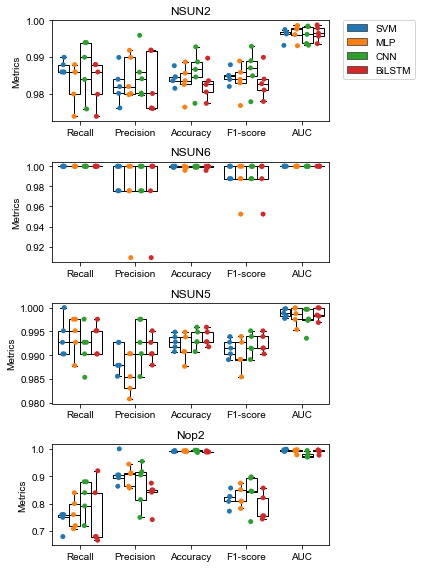

In [8]:
fig, axes = plt.subplots(4,1, figsize=(6,8))
draw_scores(axes[0], DF, group="NSUN2", draw_legend=True)
draw_scores(axes[1], DF, group="NSUN6")
draw_scores(axes[2], DF, group="NSUN5")
draw_scores(axes[3], DF, group="Nop2")
plt.tight_layout()

### 1.2 Draw confusion matrix (CV \#0)

In [9]:
def draw_confusion_matrix(ax, fn, title=None):
    ax.set_aspect('equal', 'box')
    df = pd.read_csv(fn, index_col=0, header=0)
    df_percent = df/df.sum(axis=1) * 100
    heatmap = sns.heatmap(df_percent, cmap="RdYlBu_r", annot=df, fmt="d", vmax=100, vmin=0, ax=ax, cbar_kws={"shrink":0.75})
    ax.set_xlabel("Predict value")
    ax.set_ylabel("True value")
    ax.set_title(title)

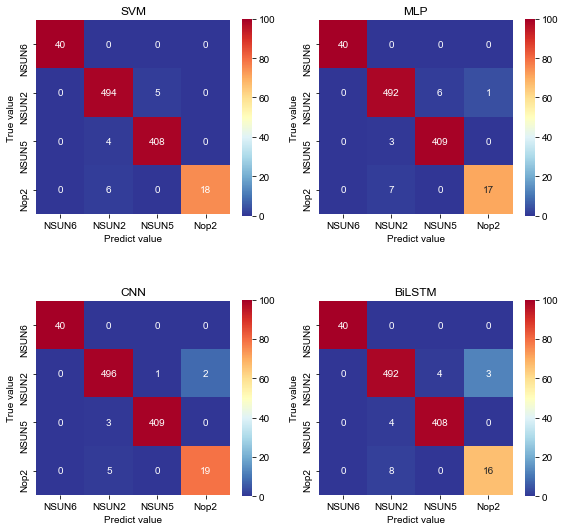

In [10]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
draw_confusion_matrix(axes[0][0], "./SVM/CV_0/confusion_matrix.csv", "SVM")
draw_confusion_matrix(axes[0][1], "./MLP/CV_0/confusion_matrix.csv", "MLP")
draw_confusion_matrix(axes[1][0], "./CNN1D/CV_0/confusion_matrix.csv", "CNN")
draw_confusion_matrix(axes[1][1], "./BiLSTM/CV_0/confusion_matrix.csv", "BiLSTM")
plt.tight_layout()

### 1.3 AUCROC (CV #0)

In [11]:
def draw_AUCROC(ax, folder, title):
    df_auc = pd.read_csv(folder+"/auc.csv", index_col=0, header=0)
    for i in ["NSUN2", "NSUN6", "NSUN5", "Nop2"]:
        fn = folder + "/" + i + "_ROC.csv"
        df = pd.read_csv(fn)
        ax.plot(df["FPR"], df["TPR"], label="{} (auc={})".format(i, round(df_auc.loc[i, "AUC"], 3)))
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc=4)
    ax.set_title(title)

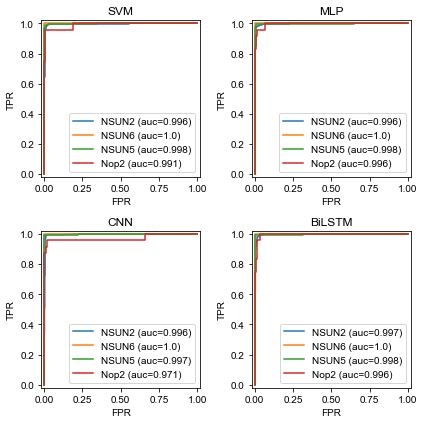

In [12]:
fig, axes = plt.subplots(2,2, figsize=(6,6))
draw_AUCROC(axes[0][0], "./SVM/CV_0/", "SVM")
draw_AUCROC(axes[0][1], "./MLP/CV_0/", "MLP")
draw_AUCROC(axes[1][0], "./CNN1D/CV_0/", "CNN")
draw_AUCROC(axes[1][1], "./BiLSTM/CV_0/", "BiLSTM")
plt.tight_layout()

## 2. Models

### 2.1 Draw traing curves for deep learning models

In [13]:
def read_data(folder, model_name):
    metrics_table = folder + "/mertics.csv"
    df_in = pd.read_csv(metrics_table, index_col=None, header=0)
    columns = list(df_in.columns)
    columns[0] = "Epoch"
    df_in.columns = columns
    df_in["Epoch"] = df_in.index
    df_in["Epoch"] = df_in["Epoch"] + 1
    return df_in

In [14]:
def draw_training(ax, df, title=None):
    ax.plot(df["Epoch"], df["LOSS"], "--", c="#036EB8", label="Training set")
    ax.plot(df["Epoch"], df["VAL_LOSS"], c="#036EB8", label="Validation set")
    ax2 = ax.twinx()
    ax2.plot(df["Epoch"], df["ACC"], "--", c="#D22B26")
    ax2.plot(df["Epoch"], df["VAL_ACC"], c="#D22B26")
    # ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss", color="#036EB8")
    ax.set_ylim(bottom=-0.05, top=2.71828)
    ax2.set_ylabel("Accuracy", color="#D22B26")
    ax2.set_ylim(bottom=0.35, top=1.02)
    ax.legend(loc=5)
    
    min_loss = df["VAL_LOSS"].min()
    df_min_loss = df[df["VAL_LOSS"]==min_loss]
    
    ax.scatter(df_min_loss["Epoch"], df_min_loss["VAL_LOSS"], c="black", s=20, zorder=5)
    for idx, row in df_min_loss.iterrows():
        ax.add_line(Line2D([row["Epoch"], row["Epoch"]],ax.get_ylim(), ls="--", lw=1, color="black"))
        if row["Epoch"] < 250:
            ax.annotate("Epoch={}\nval_loss={:.3f}\nval_acc={:.3f}".format(int(row["Epoch"]), row["VAL_LOSS"], row["VAL_ACC"]), xy=(row["Epoch"]+5, 0.2), ha="left", va="bottom")
        else:
            ax.annotate("Epoch={}\nval_loss={:.3f}\nval_acc={:.3f}".format(int(row["Epoch"]), row["VAL_LOSS"], row["VAL_ACC"]), xy=(row["Epoch"]-5, 0.2), ha="right", va="bottom")
    # ax2.scatter(df_min_loss["Epoch"], df_min_loss["VAL_ACC"], c="red", s=20, zorder=5)
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    ax.set_title(title)

In [15]:
training_MLP = read_data("./MLP/model/", "MLP")
training_CNN1D = read_data("./CNN1D/model/", "CNN")
training_BiLSTM = read_data("./BiLSTM/model/", "BiLSTM")

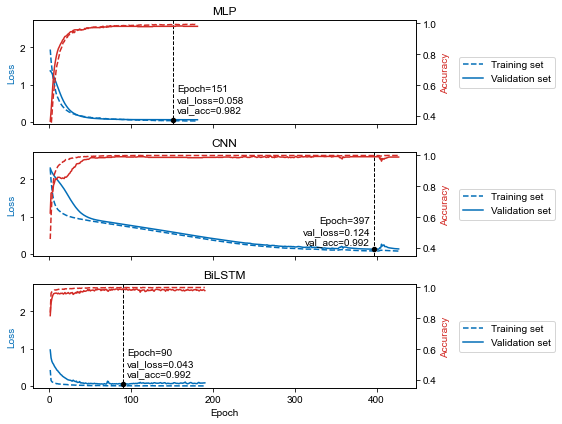

In [16]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,6))
draw_training(axes[0], training_MLP, "MLP")
draw_training(axes[1], training_CNN1D, "CNN")
draw_training(axes[2], training_BiLSTM, "BiLSTM")
axes[2].set_xlabel("Epoch")
plt.tight_layout()

### 2.2 Draw confusion matrixes

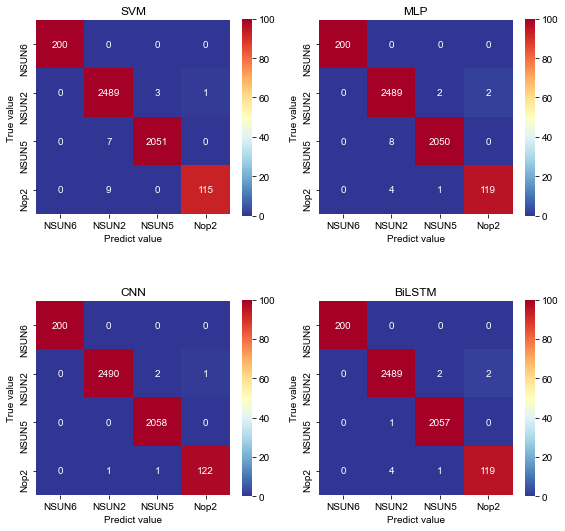

In [17]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
draw_confusion_matrix(axes[0][0], "./SVM/model/confusion_matrix.csv", "SVM")
draw_confusion_matrix(axes[0][1], "./MLP/model/confusion_matrix.csv", "MLP")
draw_confusion_matrix(axes[1][0], "./CNN1D/model/confusion_matrix.csv", "CNN")
draw_confusion_matrix(axes[1][1], "./BiLSTM/model/confusion_matrix.csv", "BiLSTM")
plt.tight_layout()

### 2.3 Draw ROCAUC

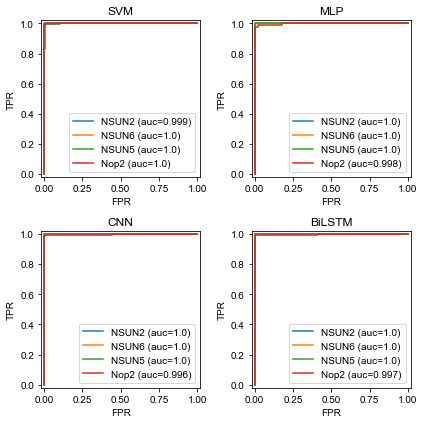

In [18]:
fig, axes = plt.subplots(2,2, figsize=(6,6))
draw_AUCROC(axes[0][0], "./SVM/model/", "SVM")
draw_AUCROC(axes[0][1], "./MLP/model/", "MLP")
draw_AUCROC(axes[1][0], "./CNN1D/model/", "CNN")
draw_AUCROC(axes[1][1], "./BiLSTM/model/", "BiLSTM")
plt.tight_layout()

## 3. Working with real data

### 3.1 Construct function marking potential writer responsible for

In [19]:
def get_prediction_results(df, model_file=None, model_type=None):
    # The file should contian column ("INFO", "motif_F10")
    df = df.copy()
    
    if model_type == "keras":
        import keras
        import tensorflow as tf
        import logging
        import absl.logging
        tf.autograph.set_verbosity(0)
        logging.getLogger("tensorflow").setLevel(logging.ERROR)
        absl.logging.set_verbosity(absl.logging.ERROR)
        
        # load keras model
        model = keras.models.load_model(model_file)
    elif model_type == "SVM":
        import pickle
        model = pickle.load(open(model_file, 'rb'))
        
    indexes = []
    onehot_input = []
    for idx, row in df.iterrows():
        indexes.append(idx)
        seq = str(row[("INFO", "motif_F10")]).upper()
        onehot = enc.transform([[i] for i in seq]).toarray()
        if model_type == "SVM":
            onehot_input.append(onehot.reshape(-1))
        else:
            onehot_input.append(onehot)
        
    if model_type == "keras":

        preds = model.predict(np.array(onehot_input))
    elif model_type == "SVM":
        preds = model.decision_function(onehot_input)
        
    def cal_Phred_score(P):
        P = 1-P
        if P < 1e-6:
            P = 1e-6
        Q = -10*np.log10(P)
        return int(round(Q))
    
    preds_argmax = np.argmax(preds, axis=1)
    preds_qual = [i for i in preds[range(0, preds_argmax.shape[0]), preds_argmax]]
    
    df[("INFO", "Prediction")] = [label_to_name.get(i) for i in preds_argmax]
    df[("INFO", "Prediction quality")] = preds_qual
    df[("INFO", "Prediction Phred")] = [cal_Phred_score(i) for i in preds_qual]
    if model_type == "keras":
        df[("INFO", "Prediction (high-qual)")] = "unknown"
        high_qual_indexes = df[df[("INFO", "Prediction quality")]>0.95].index
        df.loc[high_qual_indexes, ("INFO", "Prediction (high-qual)")] = df.loc[high_qual_indexes, ("INFO", "Prediction")]
    
    df[("INFO", "Prob NSUN6")] = preds[:,0]
    df[("INFO", "Prob NSUN2")] = preds[:,1]
    df[("INFO", "Prob NSUN5")] = preds[:,2]
    df[("INFO", "Prob Nop2")] = preds[:,3]
    
    return df

In [20]:
def curated_motifs(df):
    df = df.copy()
    df[("INFO", "Curated")] = "unknown"
    curated = []
    indexes = []
    for idx, row in df.iterrows():
        indexes.append(idx)
        seq = row[("INFO","motif_F10")]
        P_NSUN6 = row[("INFO", "Prob NSUN6")]
        P_NSUN2 = row[("INFO", "Prob NSUN2")]
        P_NSUN5 = row[("INFO", "Prob NSUN5")]
        P_Nop2 = row[("INFO", "Prob Nop2")]
        Q = row[("INFO", "Prediction quality")]
        pred = row[("INFO", "Prediction")]
        
        if seq == "ACACACCGCCCGTCACCCTCC": # NSUN4
             curated.append("NSUN4")
        elif pred == "NSUN6":
            if seq[11:15] in ["TCCA", "TCAA", "TCTA", "TCGA"] and Q >= 0.5:
                curated.append("NSUN6")
            else:
                curated.append("unknown")
        elif pred == "NSUN2":
            if Q >= 0.9:
                curated.append("NSUN2")
            elif P_Nop2 >= 0.1:
                if seq[11:16] in ["GAAGT", "GATGT", "GACGT"] and seq[9] in ["C", "T"]:
                    curated.append("Nop2")
                elif seq[11:16] in ["GAGGT", "GAGTG", "GACTG", "GAATG", "GATTG", "GAGTT", "GATTT" , "GACTT"]:
                    if seq[8:10] in ["TT", "TC", "CT"]:
                        curated.append("Nop2")
                    else:
                        curated.append("NSUN2")
                else:
                    curated.append("unknown")
            elif P_NSUN6 >= 0.1 and seq[11:15] in ["TCCA", "TCAA", "TCTA", "TCGA"]: 
                curated.append("NSUN6")
            else:
                curated.append("unknown")
        elif pred == "Nop2":
            if Q >= 0.9:
                curated.append("Nop2")
            else:
                if seq[11:16] in ["GAAGT", "GATGT", "GACGT"] and seq[9] in ["C", "T"]:
                    curated.append("Nop2")
                elif seq[11:16] in ["GAGGT", "GAGTG", "GACTG", "GAATG", "GATTG", "GAGTT", "GATTT" , "GACTT"]:
                    if seq[8:10] in ["TT", "TC", "CT"]:
                        curated.append("Nop2")
                    else:
                        curated.append("NSUN2")
                elif P_NSUN6 >= 0.1 and seq[11:15] in ["TCCA", "TCAA", "TCTA", "TCGA"]: 
                    curated.append("NSUN6")
                else:
                    curated.append("unknown")
        elif pred == "NSUN5":
            if Q >= 0.9 and seq[11:16] in ["GATGT"]:
                curated.append("Nop2")
            elif Q >= 0.9:
                curated.append("NSUN5")
            elif P_NSUN6 >= 0.1 and seq[11:15] in ["TCCA", "TCAA", "TCTA", "TCGA"]: 
                curated.append("NSUN6")
            else:
                curated.append("unknown")
    df.loc[indexes, ("INFO", "Curated")] = curated
    return df

### 3.2 Predict m5C motifs in Noc-treated HeLa cells

In [21]:
df_Noc = pd.read_csv("./HeLa_Noc_NSUNs.motif.F10.clustered.curated.csv", index_col=[0,1,2], header=[0,1])

**Predict with SVM**

In [22]:
df_Noc_SVM = get_prediction_results(df_Noc, model_file="./SVM/model/m5C_motifs_21nt_SVM.h5", model_type="SVM")

In [23]:
print("Softmax predictions:")
print(df_Noc_SVM.xs("INFO", axis=1, level=0).groupby(by=["Prediction"])["Prediction"].count())

Softmax predictions:
Prediction
NSUN2    11342
NSUN5      388
NSUN6      417
Nop2       537
Name: Prediction, dtype: int64


**Predict with CNN**

In [24]:
df_Noc_CNN = get_prediction_results(df_Noc, model_file="./CNN1D/model/m5C_motifs_21nt_CNN1D.h5", model_type="keras")

In [25]:
df_Noc_CNN = curated_motifs(df_Noc_CNN)

In [26]:
print("Softmax predictions:")
print(df_Noc_CNN.xs("INFO", axis=1, level=0).groupby(by=["Prediction"])["Prediction"].count())

Softmax predictions:
Prediction
NSUN2    11075
NSUN5      504
NSUN6      451
Nop2       654
Name: Prediction, dtype: int64


In [27]:
print("High quality predictions:")
print(df_Noc_CNN.xs("INFO", axis=1, level=0).groupby(by=["Prediction (high-qual)"])["Prediction"].count())

High quality predictions:
Prediction (high-qual)
NSUN2      10685
NSUN5        354
NSUN6        369
Nop2         567
unknown      709
Name: Prediction, dtype: int64


In [28]:
print("Curated:")
print(df_Noc_CNN.xs("INFO", axis=1, level=0).groupby(by=["Curated"])["Curated"].count())

Curated:
Curated
NSUN2      10810
NSUN4          1
NSUN5        380
NSUN6        347
Nop2         626
unknown      520
Name: Curated, dtype: int64


**Define useful functions**

In [29]:
def fisher_plot(row, X, Y, alternative="less"):
    if row[(X, "coverage")] >= 20 and row[(Y, "coverage")] >= 20:
        T = row[(X, "coverage")]
        C = row[(X, "C count")]
        t = row[(Y, "coverage")]
        c = row[(Y, "C count")]
        odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative=alternative)
        return pvalue
    else:
        return 1

In [30]:
def draw_one(ax, df, X, Y, indexes=None, alternative="less", draw_cbar=False, xlabel=None, ylabel=None):
    df = df.copy()
    df = df.loc[indexes]
    
    df = df[(df[(X, "coverage")]>=20)&(df[(Y, "coverage")]>=20)]
    if df.shape[0] > 0:
        df[("INFO", "pvalue")] = df.apply(lambda x: fisher_plot(x, X, Y, alternative=alternative), axis=1)
    
        ax.set_aspect('equal', 'box')

        scatter= ax.scatter(x=df[(X, "m5C level")],
                      y=df[(Y, "m5C level")],
                      alpha=1.0, s=3,
                      c=df[("INFO","pvalue")],
                      norm=LogNorm(vmin=0.001, vmax=1.0))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        Line1 = Line2D(ax.get_xlim(),ax.get_ylim(),color='k',linestyle='--',alpha=1,linewidth=0.8)
        ax.add_line(Line1)
        if draw_cbar == True:
            cbar = plt.colorbar(scatter)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        sig = df[df[("INFO","pvalue")]<0.05].shape[0]
        text = "Sites: {}\np<0.05: {} ({:.2%})".format(df.shape[0], sig, sig/(df.shape[0]+0.0))
        ax.annotate(text, xy=(0.05,0.95), xycoords="axes fraction", ha="left", va="top")
    else:
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        Line1 = Line2D(ax.get_xlim(),ax.get_ylim(),color='k',linestyle='--',alpha=1,linewidth=0.8)
        ax.add_line(Line1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

In [31]:
def draw_Noc(df, column_to_use=("INFO", "Prediction"), with_unknown=False):
    df = df.copy()
    df = df[df[("WT_Noc", "passed")] == True]
    if with_unknown == False:
        fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(9,9))
    else:
        fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(11,9))

    NSUN2_filtered = df[df[column_to_use] == "NSUN2"].index
    NSUN6_filtered = df[df[column_to_use] == "NSUN6"].index
    NSUN5_filtered = df[df[column_to_use] == "NSUN5"].index
    Nop2_filtered = df[df[column_to_use] == "Nop2"].index
    if with_unknown == True:
        unknown_sites = df[df[column_to_use] == "unknown"].index
        ax_list = [0,1,2,3,4]
        col_vars = [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered, unknown_sites]
        col_labs = ["NSUN2", "NSUN6", "NSUN5", "Nop2", "unknown"]
    else:
        ax_list = [0,1,2,3]
        col_vars = [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered]
        col_labs = ["NSUN2", "NSUN6", "NSUN5", "Nop2"]
    
    for i, filter, title in zip(*[ax_list, col_vars, col_labs]):
        if i == 0:
            draw_one(axes[0][i], df, "WT_Noc", "KO_N2", indexes=filter, ylabel="HeLa NSUN2 KO (Noc)")
        else:
            draw_one(axes[0][i], df, "WT_Noc", "KO_N2", indexes=filter)
        axes[0][i].set_title(title)
    for i, filter, title in zip(*[ax_list, col_vars, col_labs]):
        if i == 0:
            draw_one(axes[1][i], df, "WT_Noc", "KO_N6", indexes=filter, ylabel="HeLa NSUN6 KO (Noc)")
        else:
            draw_one(axes[1][i], df, "WT_Noc", "KO_N6", indexes=filter)

    for i, filter, title in zip(*[ax_list, col_vars, col_labs]):
        if i == 0:
            draw_one(axes[2][i], df, "WT_Noc", "KO_N5", indexes=filter, ylabel="HeLa NSUN5 KO (Noc)")
        else:
            draw_one(axes[2][i], df, "WT_Noc", "KO_N5", indexes=filter, xlabel="")

    for i, filter, title in zip(*[ax_list, col_vars, col_labs]):
        if i == 0:
            draw_one(axes[3][i], df, "WT_Noc", "si_N1", indexes=filter, xlabel="HeLa (Noc)", ylabel="HeLa siNop2 (Noc)")
        else:
            draw_one(axes[3][i], df, "WT_Noc", "si_N1", indexes=filter, xlabel="HeLa (Noc)")

    plt.tight_layout()

#### 3.2.1 Draw m5C levels (SVM)

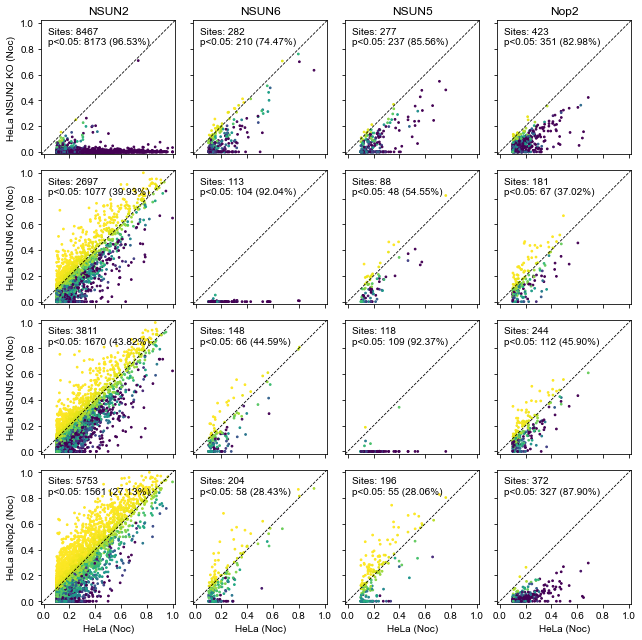

In [32]:
draw_Noc(df_Noc_SVM)

#### 3.2.1 Draw m5C levels (CNN)

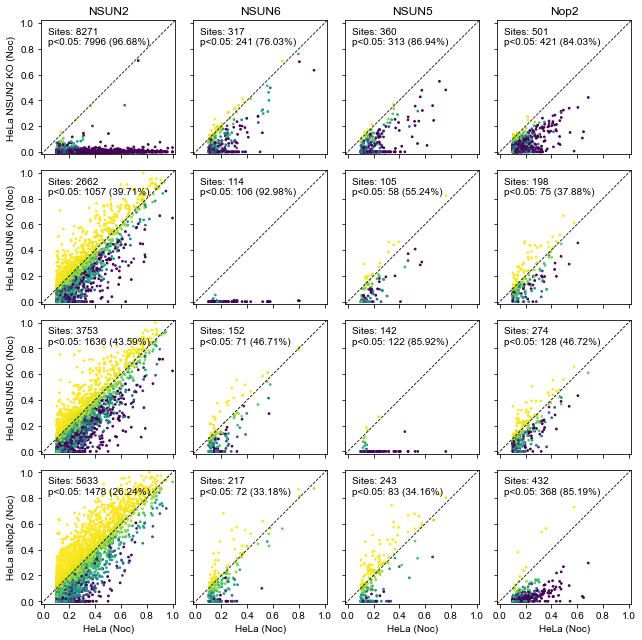

In [33]:
draw_Noc(df_Noc_CNN)

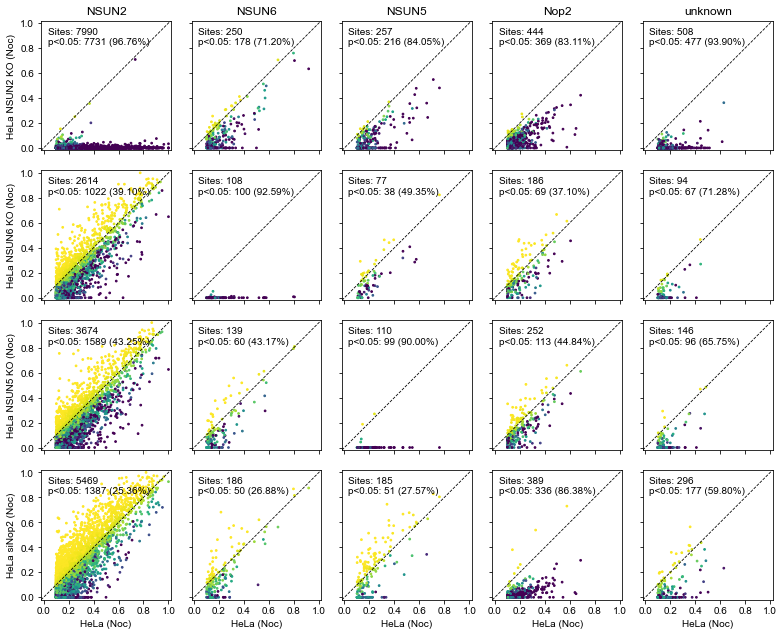

In [34]:
draw_Noc(df_Noc_CNN, column_to_use=("INFO", "Prediction (high-qual)"), with_unknown=True)

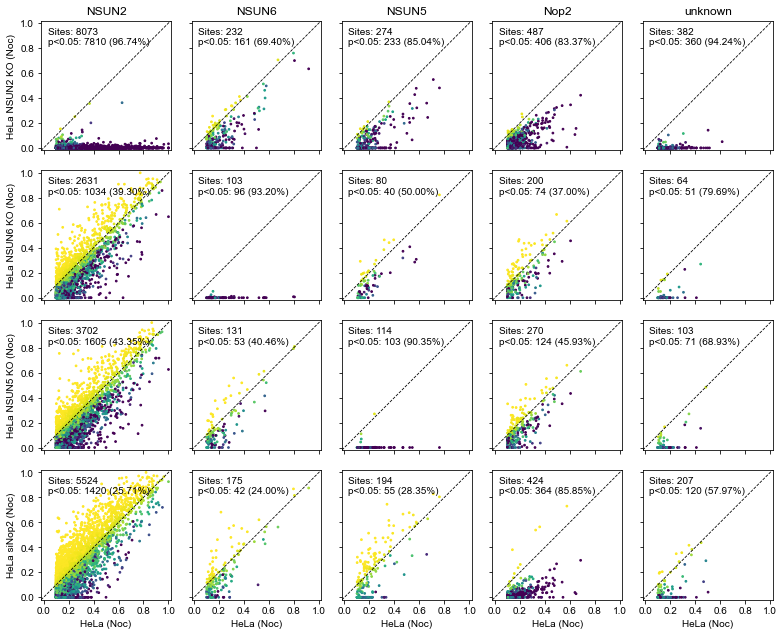

In [35]:
draw_Noc(df_Noc_CNN, column_to_use=("INFO", "Curated"), with_unknown=True)

#### 3.2.3 Draw UMAP scatters

In [36]:
def draw_UMAP(ax, df, column_used, title=None):
    clusters = ["NSUN2", "NSUN6", "NSUN5", "Nop2", "unknown"]
    for i in clusters:
        subdf = df[df[column_used]==i]
        if i == "unknown":
            ax.scatter(subdf["X"], subdf["Y"], s=1, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=1, alpha=1, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)

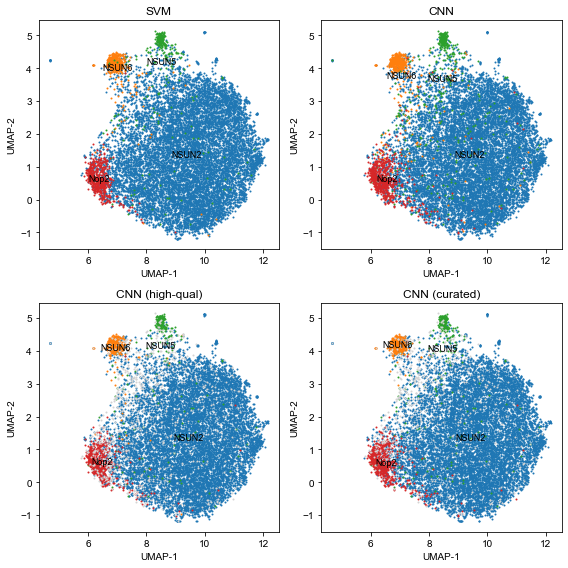

In [37]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
draw_UMAP(axes[0][0], df_Noc_SVM, ("INFO", "Prediction"), title="SVM")
draw_UMAP(axes[0][1], df_Noc_CNN, ("INFO", "Prediction"), title="CNN")
draw_UMAP(axes[1][0], df_Noc_CNN, ("INFO", "Prediction (high-qual)"), title="CNN (high-qual)")
draw_UMAP(axes[1][1], df_Noc_CNN, ("INFO", "Curated"), title="CNN (curated)")
plt.tight_layout()

#### 3.2.4 Draw motifs

In [38]:
extract_fasta_and_draw_motifs("./HeLa_Noc_SVM_pred", df_Noc_SVM, cluster_col=("INFO", "Prediction"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./HeLa_Noc_SVM_pred ===============
Cluster #NSUN2: 11342
Cluster #NSUN5: 388
Cluster #NSUN6: 417
Cluster #Nop2: 537


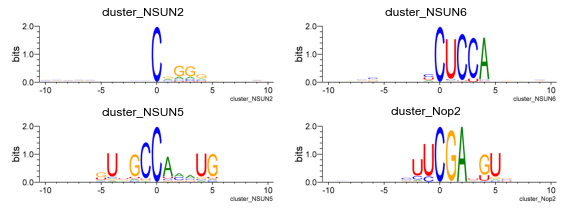

In [39]:
show_logos_cols("./HeLa_Noc_SVM_pred/logos_bits_png/", cols=2)

In [40]:
extract_fasta_and_draw_motifs("./HeLa_Noc_CNN_pred", df_Noc_CNN, cluster_col=("INFO", "Prediction"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./HeLa_Noc_CNN_pred ===============
Cluster #NSUN2: 11075
Cluster #NSUN5: 504
Cluster #NSUN6: 451
Cluster #Nop2: 654


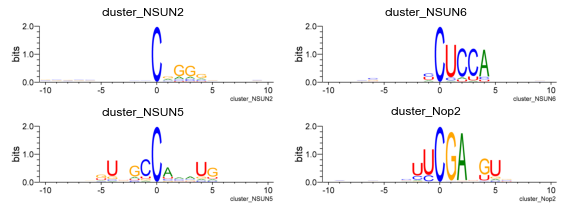

In [41]:
show_logos_cols("./HeLa_Noc_CNN_pred/logos_bits_png/", cols=2)

In [42]:
extract_fasta_and_draw_motifs("./HeLa_Noc_CNN_high_qual", df_Noc_CNN, cluster_col=("INFO", "Prediction (high-qual)"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./HeLa_Noc_CNN_high_qual ===============
Cluster #NSUN2: 10685
Cluster #NSUN5: 354
Cluster #NSUN6: 369
Cluster #Nop2: 567
Cluster #unknown: 709


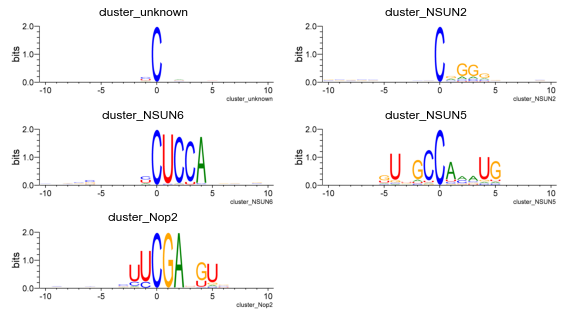

In [43]:
show_logos_cols("./HeLa_Noc_CNN_high_qual/logos_bits_png/", cols=2)

In [44]:
extract_fasta_and_draw_motifs("./HeLa_Noc_CNN_curated", df_Noc_CNN, cluster_col=("INFO", "Curated"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./HeLa_Noc_CNN_curated ===============
Cluster #NSUN2: 10810
Cluster #NSUN5: 380
Cluster #NSUN6: 347
Cluster #NSUN4: 1
Cluster #Nop2: 626
Cluster #unknown: 520


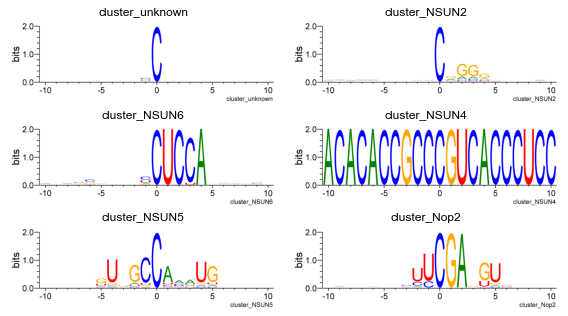

In [45]:
show_logos_cols("./HeLa_Noc_CNN_curated/logos_bits_png/", cols=2)

### 3.3 Predict m5C motifs in Human embryos

**SVM**

In [46]:
df_dev = pd.read_csv("./Human_dev.motif.F10.clustered.csv", index_col=[0,1,2], header=[0,1])

In [47]:
df_dev_SVM = get_prediction_results(df_dev, model_file="./SVM/model/m5C_motifs_21nt_SVM.h5", model_type="SVM")

In [48]:
print("Softmax predictions:")
print(df_dev_SVM.xs("INFO", axis=1, level=0).groupby(by=["Prediction"])["Prediction"].count())

Softmax predictions:
Prediction
NSUN2    30809
NSUN5      927
NSUN6     9818
Nop2       177
Name: Prediction, dtype: int64


**CNN**

In [49]:
df_dev_CNN = get_prediction_results(df_dev, model_file="./CNN1D/model/m5C_motifs_21nt_CNN1D.h5", model_type="keras")

In [50]:
df_dev_CNN = curated_motifs(df_dev_CNN)

In [51]:
print("Softmax predictions:")
print(df_dev_CNN.xs("INFO", axis=1, level=0).groupby(by=["Prediction"])["Prediction"].count())

Softmax predictions:
Prediction
NSUN2    30566
NSUN5     1117
NSUN6     9720
Nop2       328
Name: Prediction, dtype: int64


In [52]:
print("High quality predictions:")
print(df_dev_CNN.xs("INFO", axis=1, level=0).groupby(by=["Prediction (high-qual)"])["Prediction"].count())

High quality predictions:
Prediction (high-qual)
NSUN2      29704
NSUN5        777
NSUN6       9415
Nop2         195
unknown     1640
Name: Prediction, dtype: int64


In [53]:
print("Curated:")
print(df_dev_CNN.xs("INFO", axis=1, level=0).groupby(by=["Curated"])["Curated"].count())

Curated:
Curated
NSUN2      29985
NSUN4          1
NSUN5        843
NSUN6       9641
Nop2         240
unknown     1021
Name: Curated, dtype: int64


#### 3.3.1 Draw UMAP scatters

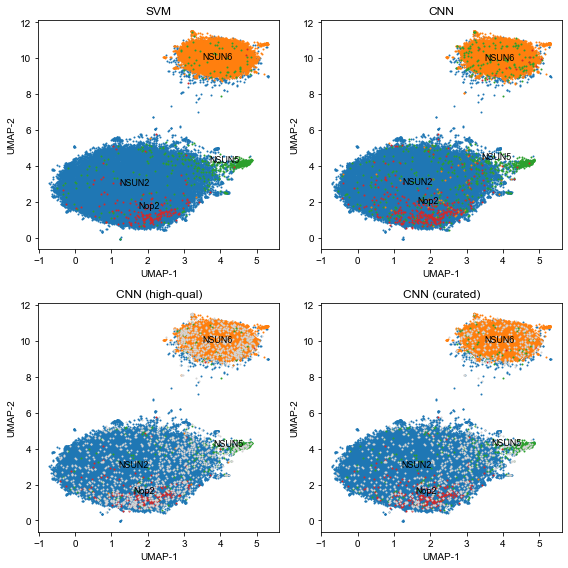

In [54]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
draw_UMAP(axes[0][0], df_dev_SVM, ("INFO", "Prediction"), title="SVM")
draw_UMAP(axes[0][1], df_dev_CNN, ("INFO", "Prediction"), title="CNN")
draw_UMAP(axes[1][0], df_dev_CNN, ("INFO", "Prediction (high-qual)"), title="CNN (high-qual)")
draw_UMAP(axes[1][1], df_dev_CNN, ("INFO", "Curated"), title="CNN (curated)")
plt.tight_layout()

In [55]:
extract_fasta_and_draw_motifs("./Human_dev_SVM_pred", df_dev_SVM, cluster_col=("INFO", "Prediction"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./Human_dev_SVM_pred ===============
Cluster #NSUN2: 30809
Cluster #NSUN5: 927
Cluster #NSUN6: 9818
Cluster #Nop2: 177


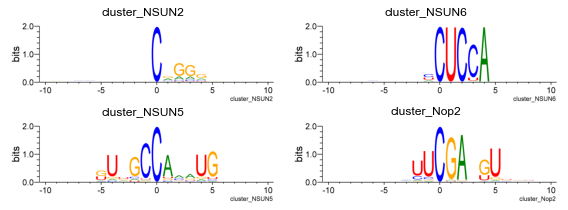

In [56]:
show_logos_cols("./Human_dev_SVM_pred/logos_bits_png/", cols=2)

In [57]:
extract_fasta_and_draw_motifs("./Human_dev_CNN_pred", df_dev_CNN, cluster_col=("INFO", "Prediction"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./Human_dev_CNN_pred ===============
Cluster #NSUN2: 30566
Cluster #NSUN5: 1117
Cluster #NSUN6: 9720
Cluster #Nop2: 328


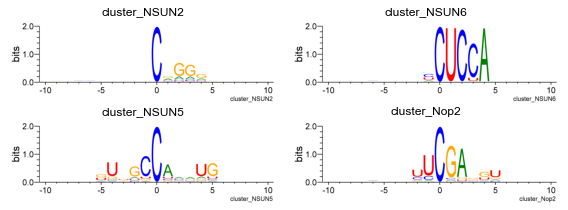

In [58]:
show_logos_cols("./Human_dev_CNN_pred/logos_bits_png/", cols=2)

In [59]:
extract_fasta_and_draw_motifs("./Human_dev_CNN_high_qual", df_dev_CNN, cluster_col=("INFO", "Prediction (high-qual)"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./Human_dev_CNN_high_qual ===============
Cluster #NSUN2: 29704
Cluster #NSUN5: 777
Cluster #unknown: 1640
Cluster #Nop2: 195
Cluster #NSUN6: 9415


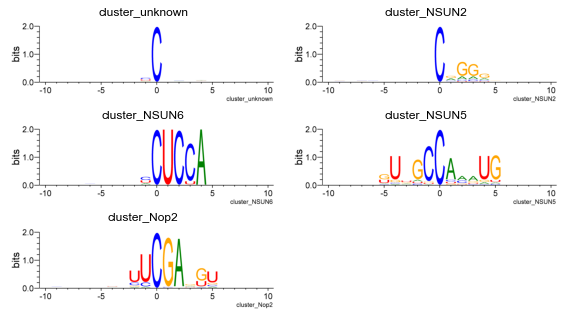

In [60]:
show_logos_cols("./Human_dev_CNN_high_qual/logos_bits_png/", cols=2)

In [61]:
extract_fasta_and_draw_motifs("./Human_dev_CNN_curated", df_dev_CNN, cluster_col=("INFO", "Curated"), filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True)

===============  ./Human_dev_CNN_curated ===============
Cluster #NSUN2: 29985
Cluster #NSUN5: 843
Cluster #unknown: 1021
Cluster #NSUN4: 1
Cluster #Nop2: 240
Cluster #NSUN6: 9641


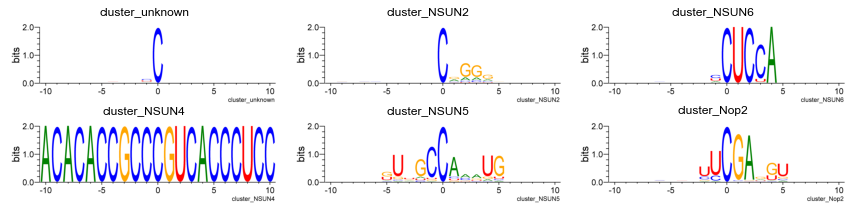

In [62]:
show_logos_cols("./Human_dev_CNN_curated/logos_bits_png/", cols=3)

#### 3.3.2 Comparing prediction results

**Venn diagram (Noc-treated HeLa)**

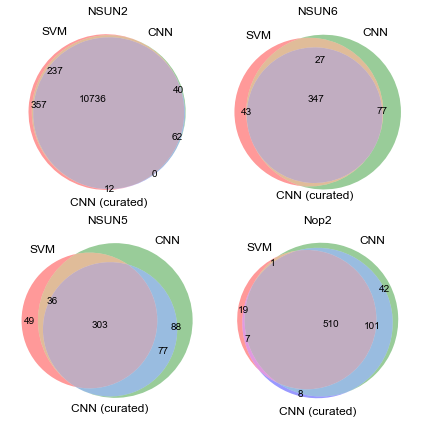

In [63]:
set1_Noc_Nop2 = set(df_Noc_SVM[df_Noc_SVM[("INFO", "Prediction")]=="Nop2"].index.get_level_values(0).tolist())
set2_Noc_Nop2 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Prediction")]=="Nop2"].index.get_level_values(0).tolist())
set3_Noc_Nop2 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Curated")]=="Nop2"].index.get_level_values(0).tolist())

set1_Noc_NSUN5 = set(df_Noc_SVM[df_Noc_SVM[("INFO", "Prediction")]=="NSUN5"].index.get_level_values(0).tolist())
set2_Noc_NSUN5 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Prediction")]=="NSUN5"].index.get_level_values(0).tolist())
set3_Noc_NSUN5 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Curated")]=="NSUN5"].index.get_level_values(0).tolist())

set1_Noc_NSUN2 = set(df_Noc_SVM[df_Noc_SVM[("INFO", "Prediction")]=="NSUN2"].index.get_level_values(0).tolist())
set2_Noc_NSUN2 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Prediction")]=="NSUN2"].index.get_level_values(0).tolist())
set3_Noc_NSUN2 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Curated")]=="NSUN2"].index.get_level_values(0).tolist())

set1_Noc_NSUN6 = set(df_Noc_SVM[df_Noc_SVM[("INFO", "Prediction")]=="NSUN6"].index.get_level_values(0).tolist())
set2_Noc_NSUN6 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Prediction")]=="NSUN6"].index.get_level_values(0).tolist())
set3_Noc_NSUN6 = set(df_Noc_CNN[df_Noc_CNN[("INFO", "Curated")]=="NSUN6"].index.get_level_values(0).tolist())

fig, axes = plt.subplots(2,2, figsize=(6,6))

venn3([set1_Noc_NSUN2, set2_Noc_NSUN2, set3_Noc_NSUN2], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[0][0])
venn3([set1_Noc_NSUN6, set2_Noc_NSUN6, set3_Noc_NSUN6], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[0][1])
venn3([set1_Noc_Nop2, set2_Noc_Nop2, set3_Noc_Nop2], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[1][1])
venn3([set1_Noc_NSUN5, set2_Noc_NSUN5, set3_Noc_NSUN5], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[1][0])

axes[0][0].set_title("NSUN2")
axes[0][1].set_title("NSUN6")
axes[1][1].set_title("Nop2")
axes[1][0].set_title("NSUN5")
plt.tight_layout()

**Venn diagram (Developmental)**

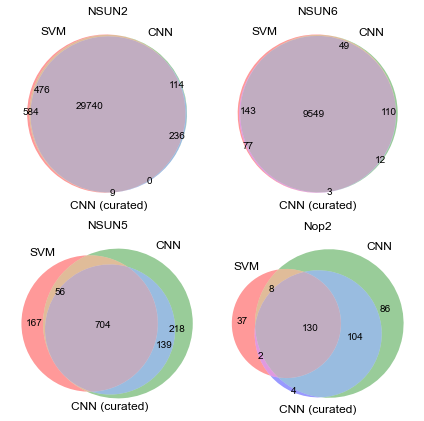

In [64]:
set1_dev_Nop2 = set(df_dev_SVM[df_dev_SVM[("INFO", "Prediction")]=="Nop2"].index.get_level_values(0).tolist())
set2_dev_Nop2 = set(df_dev_CNN[df_dev_CNN[("INFO", "Prediction")]=="Nop2"].index.get_level_values(0).tolist())
set3_dev_Nop2 = set(df_dev_CNN[df_dev_CNN[("INFO", "Curated")]=="Nop2"].index.get_level_values(0).tolist())

set1_dev_NSUN5 = set(df_dev_SVM[df_dev_SVM[("INFO", "Prediction")]=="NSUN5"].index.get_level_values(0).tolist())
set2_dev_NSUN5 = set(df_dev_CNN[df_dev_CNN[("INFO", "Prediction")]=="NSUN5"].index.get_level_values(0).tolist())
set3_dev_NSUN5 = set(df_dev_CNN[df_dev_CNN[("INFO", "Curated")]=="NSUN5"].index.get_level_values(0).tolist())

set1_dev_NSUN2 = set(df_dev_SVM[df_dev_SVM[("INFO", "Prediction")]=="NSUN2"].index.get_level_values(0).tolist())
set2_dev_NSUN2 = set(df_dev_CNN[df_dev_CNN[("INFO", "Prediction")]=="NSUN2"].index.get_level_values(0).tolist())
set3_dev_NSUN2 = set(df_dev_CNN[df_dev_CNN[("INFO", "Curated")]=="NSUN2"].index.get_level_values(0).tolist())

set1_dev_NSUN6 = set(df_dev_SVM[df_dev_SVM[("INFO", "Prediction")]=="NSUN6"].index.get_level_values(0).tolist())
set2_dev_NSUN6 = set(df_dev_CNN[df_dev_CNN[("INFO", "Prediction")]=="NSUN6"].index.get_level_values(0).tolist())
set3_dev_NSUN6 = set(df_dev_CNN[df_dev_CNN[("INFO", "Curated")]=="NSUN6"].index.get_level_values(0).tolist())

fig, axes = plt.subplots(2,2, figsize=(6,6))

venn3([set1_dev_NSUN2, set2_dev_NSUN2, set3_dev_NSUN2], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[0][0])
venn3([set1_dev_NSUN6, set2_dev_NSUN6, set3_dev_NSUN6], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[0][1])
venn3([set1_dev_Nop2, set2_dev_Nop2, set3_dev_Nop2], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[1][1])
venn3([set1_dev_NSUN5, set2_dev_NSUN5, set3_dev_NSUN5], ('SVM', 'CNN', 'CNN (curated)'), ax=axes[1][0])

axes[0][0].set_title("NSUN2")
axes[0][1].set_title("NSUN6")
axes[1][1].set_title("Nop2")
axes[1][0].set_title("NSUN5")
plt.tight_layout()

**Venn diagram (Developmental vs HeLa Noc)**

In [65]:
exp_NSUN2= set([seq.id for seq in SeqIO.parse("NSUN2.F10.fa", "fasta")])
exp_NSUN6= set([seq.id for seq in SeqIO.parse("NSUN6.F10.fa", "fasta")])
exp_NSUN5= set([seq.id for seq in SeqIO.parse("NSUN5.F10.fa", "fasta")])
exp_Nop2 = set([seq.id for seq in SeqIO.parse("Nop2.F10.fa", "fasta")])

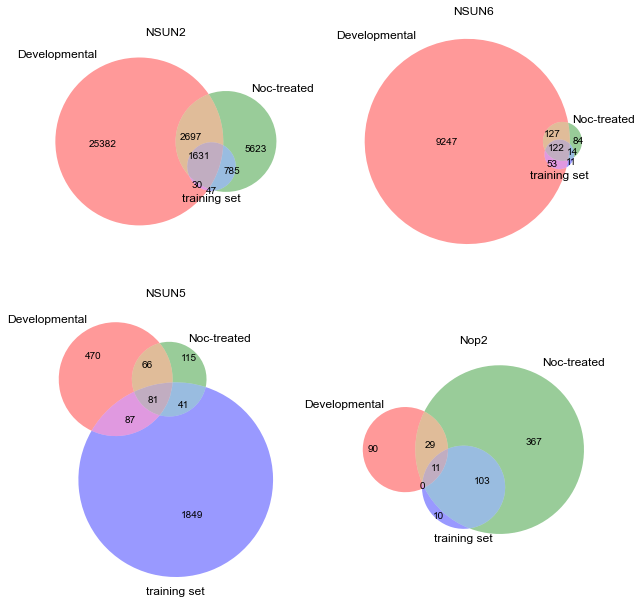

In [66]:
dev_NSUN2 = set1_dev_NSUN2 & set2_dev_NSUN2 & set3_dev_NSUN2
Noc_NSUN2 = set1_Noc_NSUN2 & set2_Noc_NSUN2 & set3_Noc_NSUN2

dev_Nop2 = set1_dev_Nop2 & set2_dev_Nop2 & set3_dev_Nop2
Noc_Nop2 = set1_Noc_Nop2 & set2_Noc_Nop2 & set3_Noc_Nop2

dev_NSUN5 = set1_dev_NSUN5 & set2_dev_NSUN5 & set3_dev_NSUN5
Noc_NSUN5 = set1_Noc_NSUN5 & set2_Noc_NSUN5 & set3_Noc_NSUN5

dev_NSUN6 = set1_dev_NSUN6 & set2_dev_NSUN6 & set3_dev_NSUN6
Noc_NSUN6 = set1_Noc_NSUN6 & set2_Noc_NSUN6 & set3_Noc_NSUN6

fig, axes = plt.subplots(2,2, figsize=(9,9))

venn3([dev_NSUN2, Noc_NSUN2, exp_NSUN2], ('Developmental', 'Noc-treated', 'training set'), ax=axes[0][0])
venn3([dev_NSUN6, Noc_NSUN6, exp_NSUN6], ('Developmental', 'Noc-treated', 'training set'), ax=axes[0][1])
venn3([dev_Nop2, Noc_Nop2, exp_Nop2], ('Developmental', 'Noc-treated', 'training set'), ax=axes[1][1])
venn3([dev_NSUN5, Noc_NSUN5, exp_NSUN5], ('Developmental', 'Noc-treated', 'training set'), ax=axes[1][0])

axes[0][0].set_title("NSUN2")
axes[0][1].set_title("NSUN6")
axes[1][1].set_title("Nop2")
axes[1][0].set_title("NSUN5")
plt.tight_layout()

## 4. m5C levels in developmetal stages

**Save to disk**

In [67]:
df_Noc_SVM.to_csv("HeLa_Noc.SVM.csv")
df_Noc_CNN.to_csv("HeLa_Noc.CNN.csv")
df_dev_SVM.to_csv("Human_dev.SVM.csv")
df_dev_CNN.to_csv("Human_dev.CNN.csv")